In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import display
from itertools import combinations_with_replacement, combinations, product

In [2]:
plt.rcParams["figure.figsize"] = (20, 20)

## Data Preprocessing

#### Edges

In [3]:
edges_df = pd.read_csv('edges.csv')

In [4]:
edges_df.head()

,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251


#### Nodes

In [5]:
nodes_df = pd.read_csv('nodes.csv')

In [6]:
nodes_df.loc[nodes_df.node.str.startswith('SPIDER-MAN/P'), 'node'] = "SPIDER-MAN/PETER PARKER"

In [7]:
nodes_df.head()

,node,type
0,2001 10,comic
1,2001 8,comic
2,2001 9,comic
3,24-HOUR MAN/EMMANUEL,hero
4,3-D MAN/CHARLES CHAN,hero


#### Network

In [8]:
network = pd.read_csv('hero-network.csv')

In [9]:
# drop self-loops
network = network[~(network.hero1 == network.hero2)].reset_index(drop=True)

# network[network.hero1.str.endswith('/')] = network[network.hero1.str.endswith('/')].apply(lambda row: row.str.strip('/'))
# network[network.hero2.str.endswith('/')] = network[network.hero2.str.endswith('/')].apply(lambda row: row.str.strip('/'))

# network = network.apply(lambda row: row.str.strip())

network.loc[network.hero1.str.startswith('SPIDER-MAN/P'), 'hero1'] = "SPIDER-MAN/PETER PARKER"
network.loc[network.hero2.str.startswith('SPIDER-MAN/P'), 'hero2'] = "SPIDER-MAN/PETER PARKER"

network.loc[network.hero1.str.startswith('BLADE'), 'hero1'] = "BLADE/"
network.loc[network.hero2.str.startswith('BLADE'), 'hero2'] = "BLADE/"

network.loc[network.hero1.str.startswith('SABRE'), 'hero1'] = "SABRE/"
network.loc[network.hero2.str.startswith('SABRE'), 'hero2'] = "SABRE/"

In [10]:
network.head()

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL


#### Finding  inconsistencies

Some heroes' names in 'hero-netowrk.csv' have extra spaces at the end of their names compared to their names in 'edges.csv'.

Some heroes' names in 'hero-netowrk.csv' have an extra '/' at the end of their names compared to their names in 'edges.csv'.

The hero name 'SPIDER-MAN/PETER PARKER' in 'edges.csv' has been changed to 'SPIDER-MAN/PETER PAR' in 'hero-network.csv' due to a string length limit in 'hero-network.csv'.

In [11]:
h1 = network.hero1.to_list()
h2 = network.hero2.to_list()

In [12]:
# Sets of heros in each df
s_network = set(list(map(str.strip, h1 + h2)))
s_edges = set(edges_df.hero)
s_nodes = set(nodes_df[nodes_df.type=="hero"].node)

In [13]:
# No more inconsistencies in edges_df and nodes_df
(s_nodes - s_edges).union(s_edges - s_nodes)

set()

In [14]:
s_network - s_edges

set()

In [15]:
(s_edges - s_network)

{'BERSERKER II',
 'BLARE/',
 'CALLAHAN, DANNY',
 'CLUMSY FOULUP',
 'DEATHCHARGE',
 'FENRIS',
 'GERVASE, LADY ALYSSA',
 'GIURESCU, RADU',
 'JOHNSON, LYNDON BAIN',
 'KULL',
 'LUNATIK II',
 'MARVEL BOY II/MARTIN',
 'RANDAK',
 'RED WOLF II',
 'RUNE',
 'SABRETOOTH | MUTANT',
 'SABRETOOTH/VICTOR CR',
 'SEA LEOPARD',
 'SHARKSKIN',
 'ZANTOR'}

In [16]:
print(len(network[(network.hero1.isin((s_edges - s_network))) | (network.hero2.isin((s_edges - s_network)))]))

0


## Graphs setup

**First graph** 

Will be constructed using the data stored in the 'hero-network.csv' file, in which an edge between two heroes can be found if they have appeared in the same comic together. The **number of edges** between two heroes represents the **number of times they have collaborated** in different comics. The graph should be considered **weighted and undirected**. It is up to you to decide which metric to use to calculate the weights, but we anticipate that the cost will be lower for heroes with more collaborations. Please specify which metric you used to select the weights in the report.


In [17]:
network

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
...,...,...
572230,COLOSSUS II/PETER RA,CALLISTO
572231,CALLISTO,ROGUE /
572232,CALLISTO,CALIBAN/
572233,CALIBAN/,ROGUE /


In [18]:
def get_hero_dict(list_of_heroes):
    index_to_hero = {} 
    hero_to_index = {}

    for ix, hero in enumerate(list_of_heroes):
        index_to_hero[ix] = hero
        hero_to_index[hero] = ix
        
    return index_to_hero, hero_to_index

In [19]:
H = ['HUMAN TORCH/JOHNNY S', 'MR. FANTASTIC/REED R']
network[(network.hero1.isin(H)) & (network.hero2.isin(H))]

,hero1,hero2
1797,MR. FANTASTIC/REED R,HUMAN TORCH/JOHNNY S
2967,MR. FANTASTIC/REED R,HUMAN TORCH/JOHNNY S
3931,MR. FANTASTIC/REED R,HUMAN TORCH/JOHNNY S
8410,HUMAN TORCH/JOHNNY S,MR. FANTASTIC/REED R
8621,MR. FANTASTIC/REED R,HUMAN TORCH/JOHNNY S
...,...,...
553188,MR. FANTASTIC/REED R,HUMAN TORCH/JOHNNY S
559302,MR. FANTASTIC/REED R,HUMAN TORCH/JOHNNY S
559323,HUMAN TORCH/JOHNNY S,MR. FANTASTIC/REED R
561890,MR. FANTASTIC/REED R,HUMAN TORCH/JOHNNY S


In [20]:
def create_G1(network_df=network, edges_df=edges_df, N=None):
   
    if N is not None: # if we want to use only top n heroes
        top_heroes = edges_df.groupby(by='hero').count().comic.sort_values(ascending=False)
        top_heroes = edges_df[edges_df["hero"].isin(top_heroes[:N].index)].reset_index(drop=True).hero.unique()
        
    else:
        top_heroes = edges_df.hero.unique()
    
    n = len(top_heroes) # number of nodes in the graph
    
    index_to_hero, hero_to_index = get_hero_dict(top_heroes)
    
    network_A = np.zeros((n, n)) # adjacency matrix

    # fill the matrix
    for ix in range(len(network_df)):
        hero1 = network_df.loc[ix].hero1
        hero2 = network_df.loc[ix].hero2
        
        if hero1 in top_heroes and hero2 in top_heroes:
        
            ix = hero_to_index[hero1]
            jx = hero_to_index[hero2]

            network_A[ix, jx] += 1
            # network_A[jx, ix] += 1
        
    network_A[network_A != 0] = 1 / network_A[network_A != 0]
    
    rows, cols = np.where(network_A != 0)

    edges = zip([index_to_hero[ix] for ix in rows.tolist()], 
                [index_to_hero[jx] for jx in cols.tolist()], 
                network_A[rows, cols])

    G = nx.MultiGraph()
    G.add_weighted_edges_from(edges)
    
    return G

**Second graph**

The data in **'nodes.csv'** and **'edges.csv'** will be used to construct the second graph. The **type of node (hero/comic)** can be found in 'nodes.csv', and **an edge** between a hero **node and a comic** node can be found in 'edges.csv' when the hero has appeared in that specific comic. This graph is assumed to be **undirected and unweighted**.

In [21]:
def create_G2(edges_df=edges_df, N=None):
    G = nx.Graph()
    
    if N is not None:
        top_heroes = edges_df.groupby(by='hero').count().comic.sort_values(ascending=False)
        edges_df = edges_df[edges_df["hero"].isin(top_heroes[:N].index)].reset_index(drop=True)
        
    for ex in range(len(edges_df)):
        hero, comic = edges_df.loc[ex]
        
        G.add_node(hero, attr='hero')
        G.add_node(comic, attr='comic')
        
        G.add_edge(hero, comic)
    
    return G

# 2. Backend Implementation

The goal of this part is the implementation of a controller system that has different functionalities. The controller should take as input an identifier "i" and run the associated function_i applied to the graph you create from the downloaded data.

**Definition**

As the number of nodes and edges grows, we may request to work on a subset of the data to reduce computation time and improve network visualization. In this case, we will ask you only to consider the data for top N heros. We define the top N heroes as follows:

**Top N heroes:** The top N heroes who have appeared in the most number of comics. The 'edges.csv' file, which represents the comics in which each hero has appeared, can be used to filter these N heroes.
Note: When the value of N is not set by the user, the function should consider the whole data.

In [22]:
def get_params(set_n=False):
    print('Please enter the graph type:')
    graph_type = input()
    
    if graph_type not in ['1', '2']:
        raise ValueError('The graph type has to be either \'1\' or \'2\'')
    
    if set_n:
        print('Now enter n for the top n heroes:')
        set_n = input()
        
        if not set_n.isnumeric():
            raise ValueError('Top heroes n has to be an integer.')
        
    return graph_type, int(set_n)

In [23]:
def create_graph(graph_type, n_heroes):
    
    if graph_type == '1':
        if n_heroes:
            G = create_G1(N=n_heroes)
        else:
            G = create_G1()
            
    if graph_type == '2':
        if n_heroes:
            G = create_G2(N=n_heroes)
        else:
            G = create_G2()
    
    return G

## Functionality 1 - extract the graph's features

**Input**

The graph data

The graph type (ex., number 1 or number 2)

N: denoting the top N heroes that their data should be considered

**Output**

~~The number of nodes in the network (if type 2, report for both node types)~~

~~The number of collaborations of each superhero with the others (only if type 1)~~

~~The number of heroes that have appeared in each comic (only if type 2)~~

~~The network's density~~

~~The network's degree distribution~~

~~The average degree of the network~~

The network's Hubs (hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution)

~~Whether the Network is sparse or dense~~

Note: For this case, it makes sense to differentiate operations between the two graphs: for example, when computing hubs for the second graph, we likely care only about comics.



In [64]:
def get_num_collaborations(G):
    V = G.nodes()
    A = nx.adjacency_matrix(G).todense()
    # A[A != 0] = np.array((1 / A[A != 0]))[0]

    return list(zip(V, np.array(A).sum(axis=0)))

In [65]:
def get_network_density(G):
    num_edges = len(G.edges) / 2
    num_nodes = len(G.nodes)
    
    max_possible_edges = (num_nodes * (num_nodes - 1)) / 2
    
    network_density = num_edges/max_possible_edges
    
    return network_density    

In [66]:
def f1(G, g_type):
    
    network_density = nx.density(G) if g_type == '2' else get_network_density(G)
    
    is_dense = network_density > 0.95
    
    
    if g_type == '1':
        n_nodes = len(G.nodes)
        
        n_collabs = get_num_collaborations(G)
        
        degree_sequence = [val/2 for nod, val in G.degree()]
        average_degree = np.mean(degree_sequence)
        
        degree_p = np.percentile(degree_sequence, 95)
        network_hubs = [(nod, val) for nod, val in G.degree() if val > degree_p]
        
        output = {'n_nodes': n_nodes,
                  'n_collabs': n_collabs,
                  'density': network_density,
                  'degree_sequence': degree_sequence,
                  'network_hubs': network_hubs,
                  'avg_degree': average_degree,
                  'is_dense': is_dense}
    
        
    if g_type == '2':
        
        comic_nodes = [x for x, y in G.nodes(data=True) if y['attr']=='comic']
        hero_nodes = [x for x, y in G.nodes(data=True) if y['attr']=='hero']
        n_nodes = {'comic': len(comic_nodes), 'hero': len(hero_nodes)}
        
        n_heroes_in_each_comic = [(node, G.degree(node)) for node in comic_nodes]
        
        hero_degree_sequence = [val for nod, val in G.degree() if nod in hero_nodes]
        comic_degree_sequence = [val for nod, val in G.degree() if nod in comic_nodes]
        degree_sequence = {'hero_degrees': hero_degree_sequence, 'comic_degrees': comic_degree_sequence}
        
        average_degree = np.mean(hero_degree_sequence + comic_degree_sequence)
        
        degree_p = np.percentile(comic_degree_sequence, 95)
        network_hubs = [(nod, val) for nod, val in G.degree() if ((val > degree_p) and (nod in comic_nodes))]
        
        output = {'n_nodes': n_nodes,
                  'n_heros_per_comic': n_heroes_in_each_comic,
                  'density': network_density,
                  'degree_sequence': degree_sequence,
                  'network_hubs': network_hubs,
                  'avg_degree': average_degree,
                  'is_dense': is_dense}
    
    return output

In [67]:
g_type, n_heroes = get_params()
G1 = create_graph(g_type, n_heroes)

Please enter the graph type:
1


In [69]:
g_type, n_heroes = get_params()
G2 = create_graph(g_type, n_heroes)

Please enter the graph type:
2


In [70]:
g1_dic = f1(G1, '1')

In [71]:
g2_dic = f1(G2, '2')

## Visualization 1 - Visualize some features of the network

We anticipate seeing the Functionality 1 report in Visualization 1. To be more specific, we expect you to have the following report format:

A table containing the following general information about the graph:

- Number of nodes in the network
- Density of the network
- Average degree of the network
- Whether the network is sparse or dense
- A table that lists the network's hubs

A plot depicting the number of collaborations of each hero in descending order (if the graph is type 1)

A plot depicting the number of heroes who appeared in each comic, sorted in descending order (if the graph is type 2)

A plot depicting the degree distribution of the network

Note: You can do the plot on a limited number of heroes/comic books to have a better visualization for the charts that ask for some insights about all of the comics/heroes (e.g. for the first 50)

In [72]:
def plot_collabs(dic, N=100):
    collab_df = pd.DataFrame(dic['n_collabs'], columns=['hero', 'n']).sort_values(by='n', ascending=False)
    collab_df.iloc[:N].plot.bar()
    
    plt.xticks(np.arange(len(collab_df['hero'][:N])), collab_df['hero'][:N])
    
    plt.xlabel('Heroes')
    plt.ylabel('Number of Collaborations')
    
    plt.show()


In [73]:
def plot_heroes_per_comic(dic, N=100):
    hero_per_comic_df = pd.DataFrame(dic['n_heros_per_comic'], columns=['comic', 'n_heros']).sort_values(by='n_heros', ascending=False)
    hero_per_comic_df.iloc[:N].plot.bar()
    
    plt.xticks(np.arange(len(hero_per_comic_df['comic'][:N])), hero_per_comic_df['comic'][:N])
    
    plt.xlabel('Comics')
    plt.ylabel('Number of Heroes')
    
    plt.show()


In [74]:
def plot_degree_distribution(g_dic):
    if type(g_dic['degree_sequence']) == list:
        plt.hist(g_dic['degree_sequence'], bins='auto')
        plt.xlabel('Hero Degrees')
        plt.ylabel('Number of Nodes')
        plt.show()
    
    else:
        hero_seq, comic_seq = g_dic['degree_sequence']['hero_degrees'], g_dic['degree_sequence']['comic_degrees']
        f, (ax1, ax2) = plt.subplots(2, 1)
        
        ax1.hist(hero_seq, bins='auto')
        ax2.hist(comic_seq, bins='auto')
        
        ax1.set_xlabel('Hero Degrees')
        ax2.set_xlabel('Comic Degrees')
        
        ax1.set_ylabel('Number of Nodes')
        ax2.set_ylabel('Number of Nodes')
        
        plt.show()
        

In [75]:
def v1(g_dic, g_type):
    out_df = pd.DataFrame()
    
    if g_type == '1':
        out_df['n_nodes'] = [g_dic['n_nodes']]
        
        plot_collabs(g_dic)
        
    if g_type == '2':
        out_df['n_hero_nodes'] = [g_dic['n_nodes']['hero']]
        out_df['n_comic_nodes'] = [g_dic['n_nodes']['comic']]
        
        plot_heroes_per_comic(g_dic)
    
    plot_degree_distribution(g_dic)
    
    out_df['density'] = [g_dic['density']]
    out_df['avg_degree'] = [g_dic['avg_degree']]
    out_df['sparsity'] = not g_dic['is_dense']
    
    hub_df = pd.DataFrame(g_dic['network_hubs'], columns=['HUB', 'degree']).sort_values(by='degree', ascending=False).reset_index(drop=True)
    display(hub_df)
    display(out_df)
    
    return out_df, hub_df

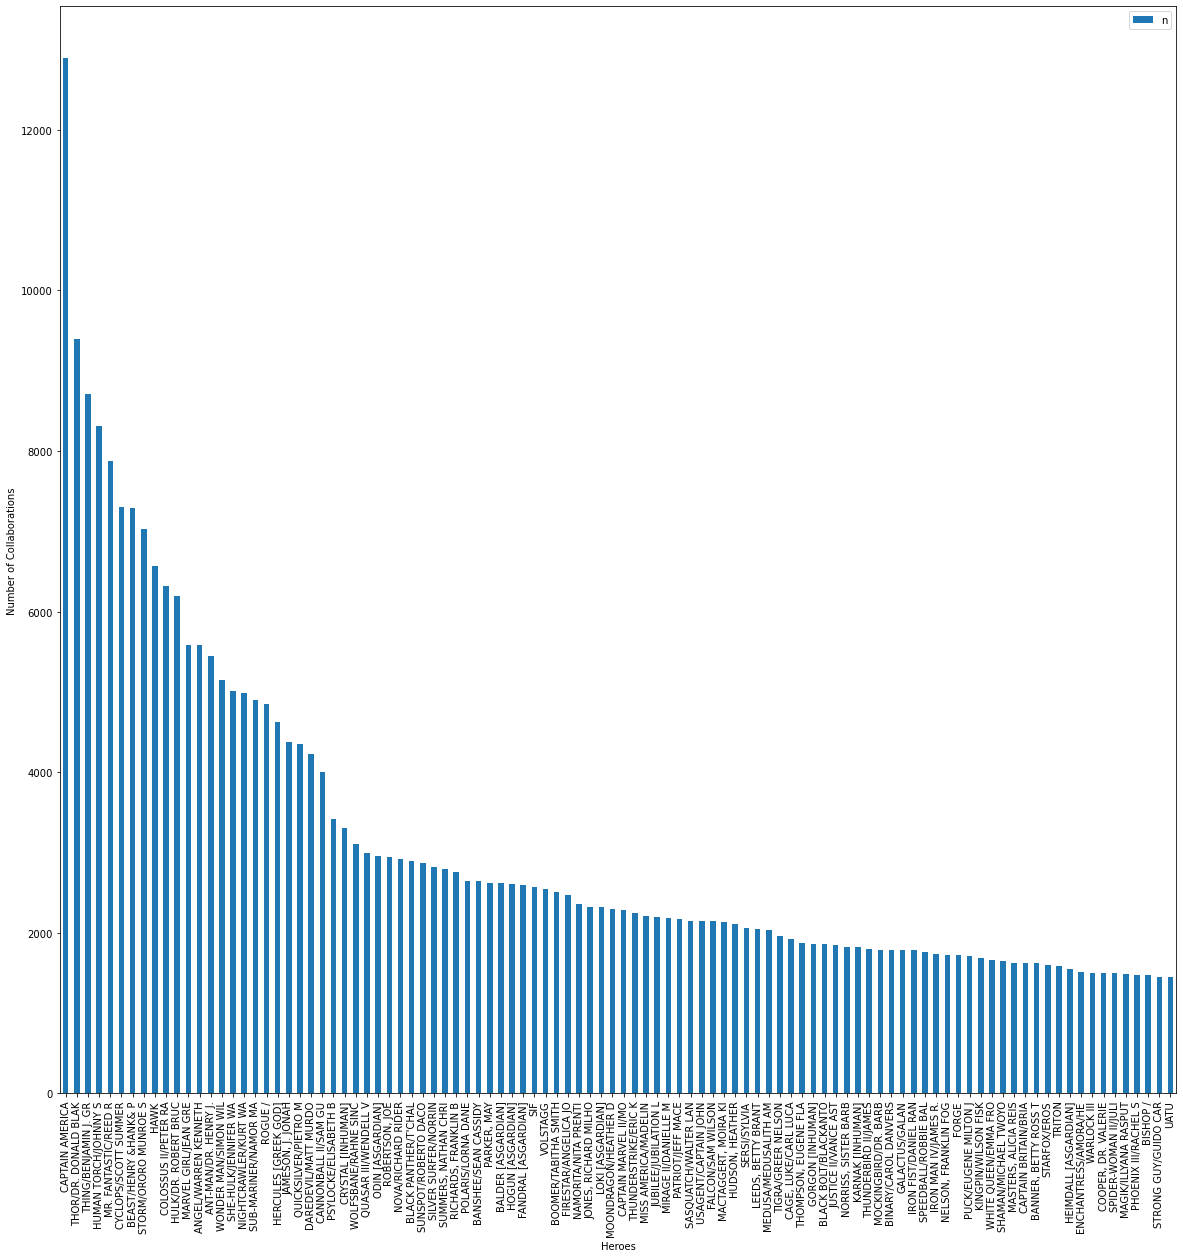

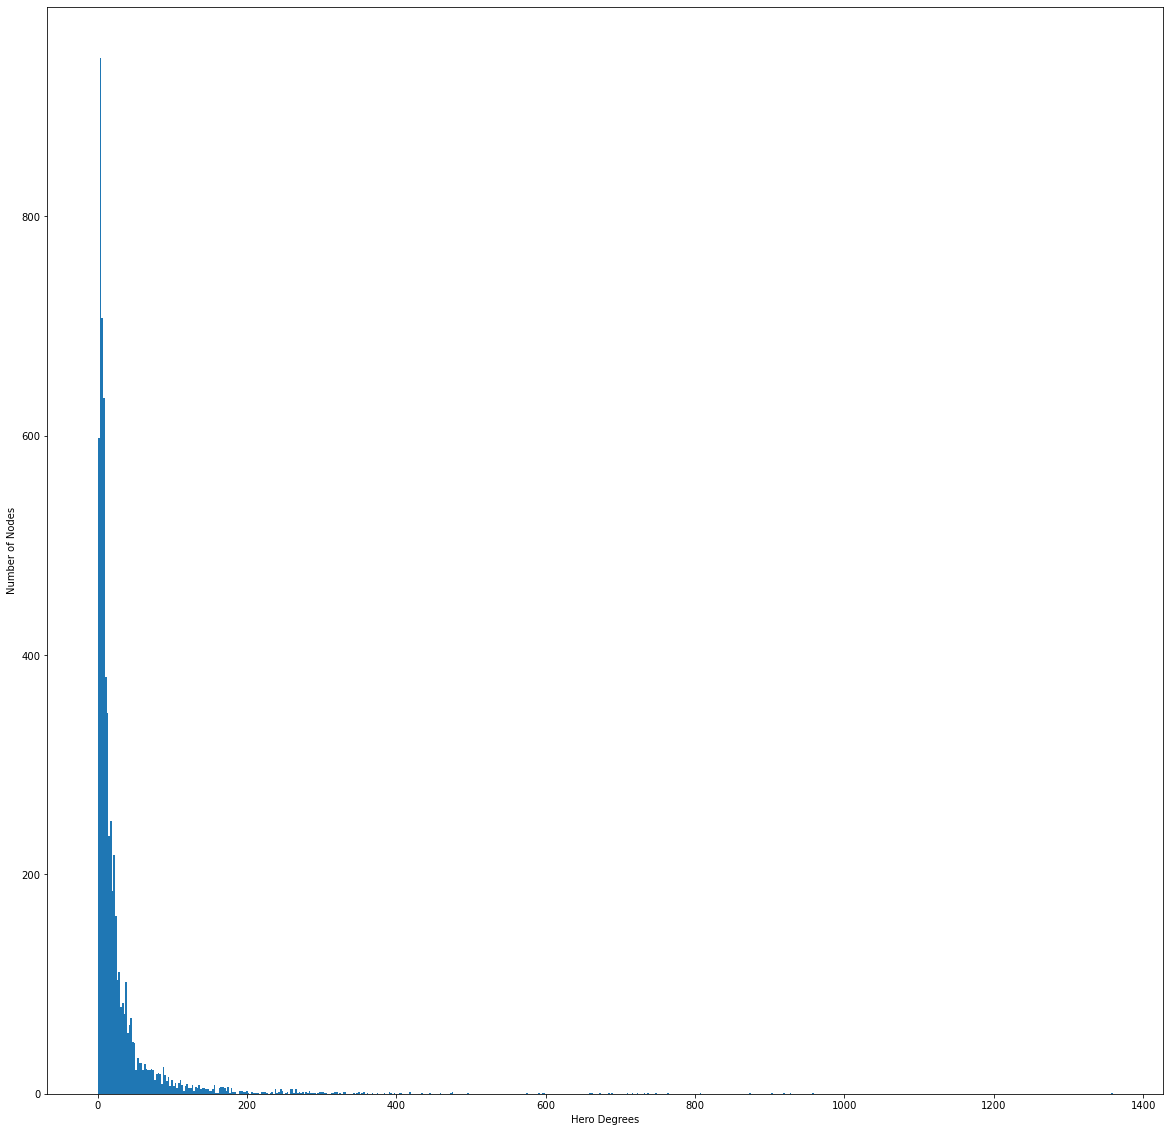

,HUB,degree
0,CAPTAIN AMERICA,2718
1,THING/BENJAMIN J. GR,1913
2,MR. FANTASTIC/REED R,1857
3,HUMAN TORCH/JOHNNY S,1838
4,THOR/DR. DONALD BLAK,1807
...,...,...
732,SUPER-ADAPTOID/ALESS,109
733,"STEELE, BOBBY",109
734,"STERMAN, ANDREA ANDI",109
735,"CARPENTER, RACHEL",109


,n_nodes,density,avg_degree,sparsity
0,6267,0.004676,29.30158,True


In [76]:
o1_df, h1_df = v1(g1_dic, '1')

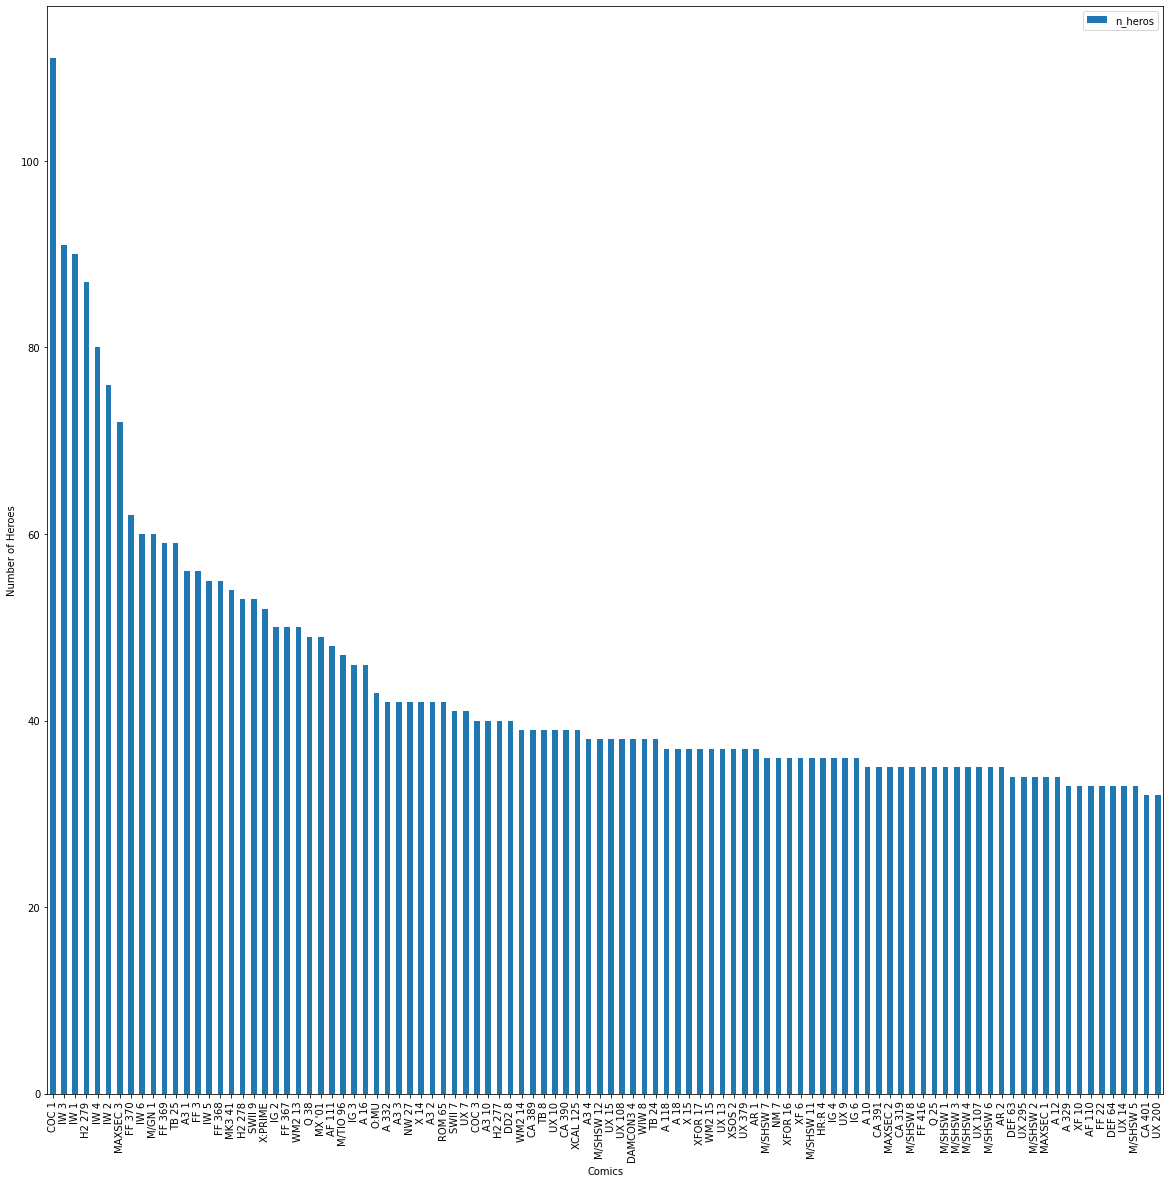

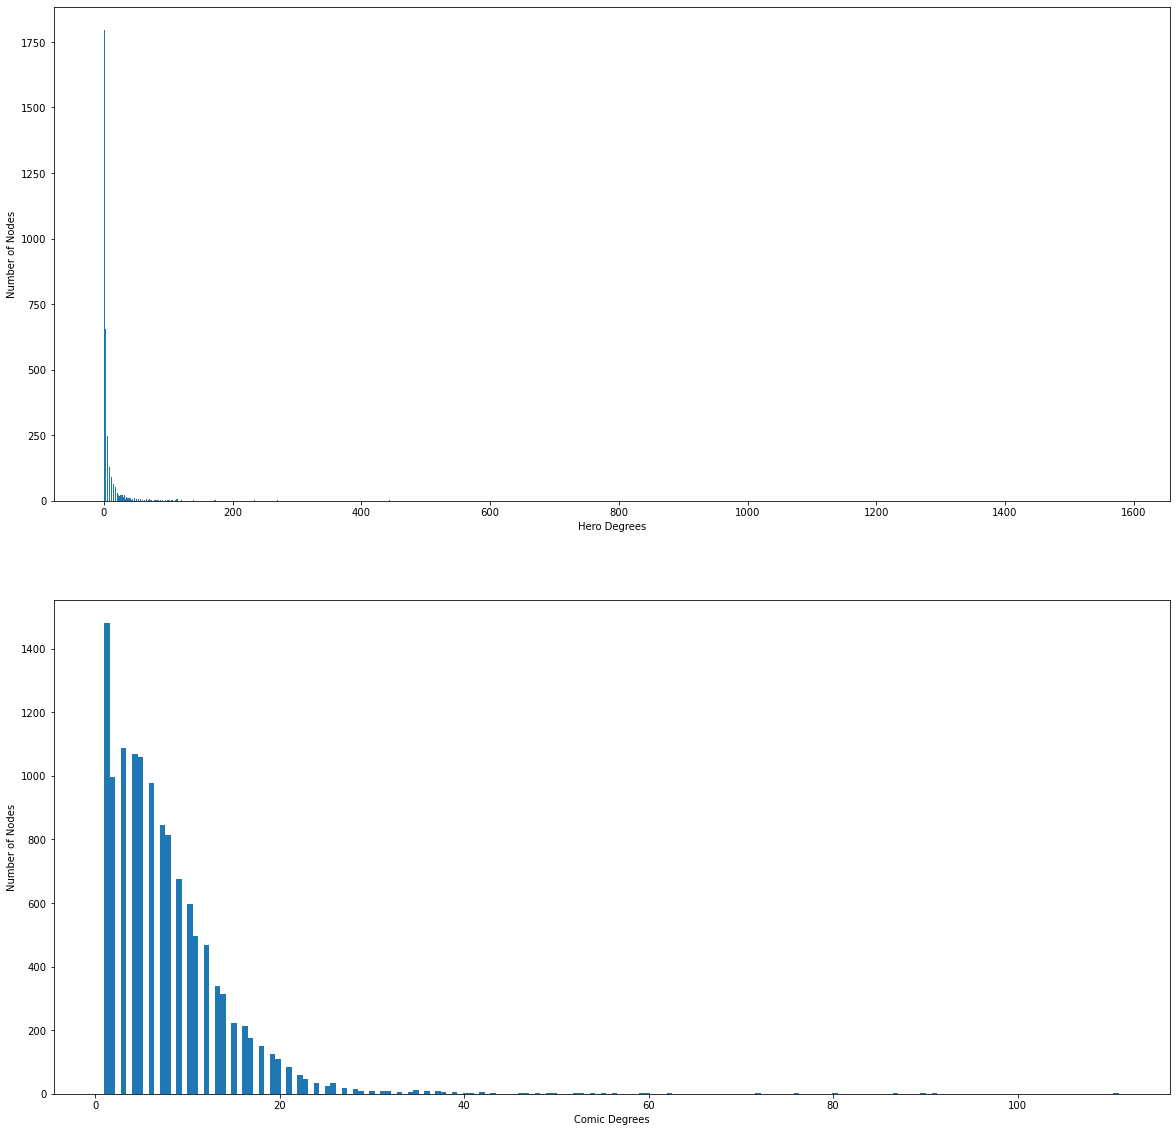

,HUB,degree
0,COC 1,111
1,IW 3,91
2,IW 1,90
3,H2 279,87
4,IW 4,80
...,...,...
548,A 187,20
549,UX 384,20
550,A 168,20
551,A 100,20


,n_hero_nodes,n_comic_nodes,density,avg_degree,sparsity
0,6439,12651,0.000527,10.068518,True


In [77]:
o2_df, h2_df = v1(g2_dic, '2')

## Functionality 4 - Disconnecting Graphs
Input:

- The graph data
- heroA: a superhero to which will relate sub-graph G_a
- heroB: a superhero to which will relate sub-graph G_b
- N: denoting the top N heroes that their data should be considered

Output:

- The minimum number of links (by considering their weights) required to disconnect the original graph in two disconnected subgraphs: G_a and G_b.

Graph 1

In [24]:
#With N=10
g_type, n_heroes = get_params(True)
print(g_type)
print(n_heroes)
G1 = create_graph(g_type, n_heroes)

Please enter the graph type:
Now enter n for the top n heroes:
1
10


"nx.to_pandas_adjacency" was used to have a better visualization of edge weights.

In [25]:
G = nx.to_pandas_adjacency(G1)
G

,CAPTAIN AMERICA,HULK/DR. ROBERT BRUC,HUMAN TORCH/JOHNNY S,MR. FANTASTIC/REED R,SPIDER-MAN/PETER PARKER,THING/BENJAMIN J. GR,THOR/DR. DONALD BLAK
CAPTAIN AMERICA,0.000000,0.036180,0.025649,0.024100,0.027810,0.024027,0.010364
HULK/DR. ROBERT BRUC,0.036180,0.000000,0.041113,0.044949,0.043256,0.040507,0.055944
HUMAN TORCH/JOHNNY S,0.025649,0.041113,0.000000,0.005614,0.027425,0.005380,0.032563
MR. FANTASTIC/REED R,0.024100,0.044949,0.005614,0.000000,0.033114,0.005655,0.031099
SPIDER-MAN/PETER PARKER,0.027810,0.043256,0.027425,0.033114,0.000000,0.032143,0.042335
THING/BENJAMIN J. GR,0.024027,0.040507,0.005380,0.005655,0.032143,0.000000,0.031947
THOR/DR. DONALD BLAK,0.010364,0.055944,0.032563,0.031099,0.042335,0.031947,0.000000


In [26]:
G = nx.to_pandas_adjacency(G1)

Then we pass the weights to a dictionary. This in order to better visualize the relationship between the Hero A and Hero B nodes.

In [27]:
# Create an empty dictionary
result = {}

# Iterate over the rows of the dataframe
for i, row in G.iterrows():
    # Get the character name from the index
    character = i
    # Initialize an empty dictionary for the character
    result[character] = {}
    # Iterate over the columns
    for col_name in G.columns:
        # Get the score value from the row
        score = row[col_name]
        # Add the score to the character's dictionary if it's not 0.000
        if score != 0.000:
            result[character][col_name] = score

print(result)

{'CAPTAIN AMERICA': {'HULK/DR. ROBERT BRUC': 0.03617992177314211, 'HUMAN TORCH/JOHNNY S': 0.02564935064935065, 'MR. FANTASTIC/REED R': 0.024099883855981417, 'SPIDER-MAN/PETER PARKER': 0.027809742999616416, 'THING/BENJAMIN J. GR': 0.02402745995423341, 'THOR/DR. DONALD BLAK': 0.010363807222445967}, 'HULK/DR. ROBERT BRUC': {'CAPTAIN AMERICA': 0.03617992177314211, 'HUMAN TORCH/JOHNNY S': 0.04111295681063123, 'MR. FANTASTIC/REED R': 0.04494949494949495, 'SPIDER-MAN/PETER PARKER': 0.043255813953488376, 'THING/BENJAMIN J. GR': 0.040507364975450086, 'THOR/DR. DONALD BLAK': 0.055944055944055944}, 'HUMAN TORCH/JOHNNY S': {'CAPTAIN AMERICA': 0.02564935064935065, 'HULK/DR. ROBERT BRUC': 0.04111295681063123, 'MR. FANTASTIC/REED R': 0.005614084817561928, 'SPIDER-MAN/PETER PARKER': 0.027425373134328357, 'THING/BENJAMIN J. GR': 0.005380231986346938, 'THOR/DR. DONALD BLAK': 0.03256302521008403}, 'MR. FANTASTIC/REED R': {'CAPTAIN AMERICA': 0.024099883855981417, 'HULK/DR. ROBERT BRUC': 0.0449494949494949

Original Graph

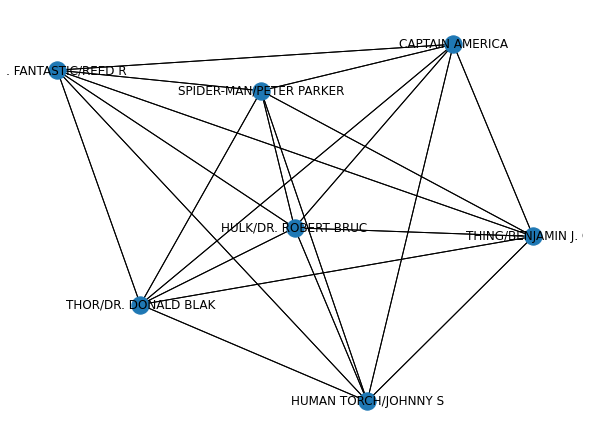

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

nx.draw(G1, with_labels=True)

In [29]:
#get_edge_data to obtain the weights of the nodes
G1.get_edge_data('CAPTAIN AMERICA', 'THOR/DR. DONALD BLAK')

{0: {'weight': 0.005235602094240838}, 1: {'weight': 0.005128205128205128}}

In [30]:
#We use nx.Graph to convert the MultiGraph to a Graph
if type(G1) == nx.MultiGraph:
    G1_ = nx.Graph(G1.copy())

In [31]:
G1_.edges('CAPTAIN AMERICA', data=True) #We have as a result one weight and a Graph instead of a MultiGraph

EdgeDataView([('CAPTAIN AMERICA', 'HULK/DR. ROBERT BRUC', {'weight': 0.019230769230769232}), ('CAPTAIN AMERICA', 'HUMAN TORCH/JOHNNY S', {'weight': 0.014285714285714285}), ('CAPTAIN AMERICA', 'MR. FANTASTIC/REED R', {'weight': 0.011904761904761904}), ('CAPTAIN AMERICA', 'SPIDER-MAN/PETER PARKER', {'weight': 0.015151515151515152}), ('CAPTAIN AMERICA', 'THING/BENJAMIN J. GR', {'weight': 0.013157894736842105}), ('CAPTAIN AMERICA', 'THOR/DR. DONALD BLAK', {'weight': 0.005128205128205128})])

In [32]:
sum([da['weight'] for s, t, da in G1_.edges('CAPTAIN AMERICA', data=True)])

0.0788588604378078

The minimum_cut() function in NetworkX takes into account the weights of the edges in the graph when computing the minimum cut. By default, it uses the weight of the edges as the measure of the "cost" of cutting the edge. In that way, we are going to obtain a partitioning of the nodes that defines the minimum cut.

In [33]:
def remove_minimum_cut_edges(G, s, t, capacity_att='weight'):
    G_aux = G.copy()
    #With nx.minimum_cut we obtain the nodes which are necessary to separate Hero A from Hero B.
    _, (nodes_set1, nodes_set2) = nx.minimum_cut(G_aux, s, t, capacity_att)

    #Edges to remove to obtain the two disconnected subgraphs
    edges_to_remove = [
        (s, t) for s, t in G_aux.edges(nodes_set1) if t in nodes_set2]

    G_aux.remove_edges_from(edges_to_remove)
    #G_aux is the final output that has the two disconnected subgraphs
    return len(edges_to_remove), G_aux

Graph 2

In [34]:
#Using N=3

g_type, n_heroes = get_params(True)
print(g_type)
print(n_heroes)
G2 = create_graph(g_type, n_heroes)

Please enter the graph type:
Now enter n for the top n heroes:
2
3


Original Graph

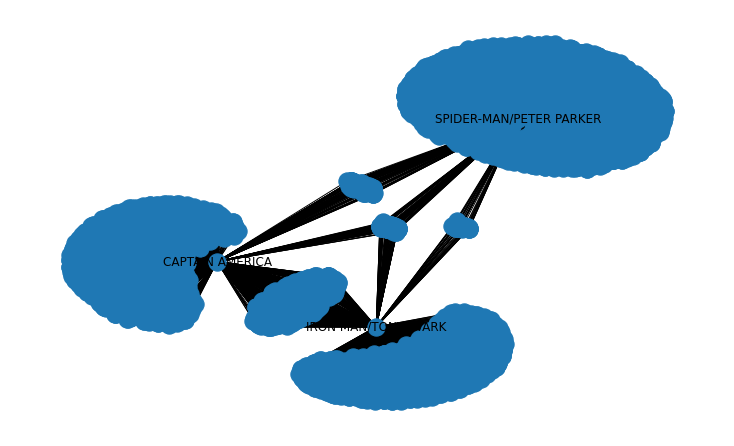

In [35]:
plt.figure(figsize=(10, 6))
# Draw hero nodes
selected_nodes = [node for node in G2.nodes if G2.nodes[node]['attr'] == 'hero']

# Draw a label for just the selected nodes
node_labels = {node:node for node in selected_nodes}
nx.draw(G2, with_labels=True, labels=node_labels)

In [36]:
G2_ = G2.copy()

display(nx.is_weighted(G2_))
#Add a weight of 1 for all nodes and in that way use Minimum_cut later
nx.set_edge_attributes(G2_, 1, "weight")

display(nx.is_weighted(G2_))

False

True

## Visualization 4 - Visualize the disconnected graph

We anticipate seeing the Functionality 4 report in Visualization 4. To be more specific, we expect you to have the following report format:

- Print the number of the links that should be disconnected
- Plot the original graph
- Plot the graph after removing the links and identify the two nodes

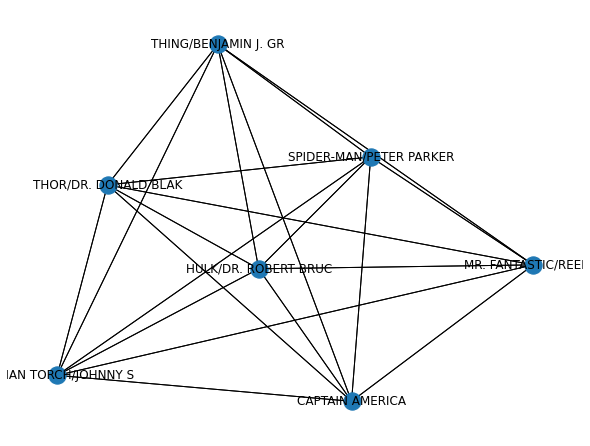

In [37]:
#Original Graph 1.
#As an example, we choose Top N = 10 and Hero A: 'CAPTAIN AMERICA' and Hero B: 'THOR/DR. DONALD BLAK'

plt.figure(figsize=(8, 6))

nx.draw(G1, with_labels=True)

The minuimum number of links (edges) necessary to separate Heroe A from Hero B are: 6


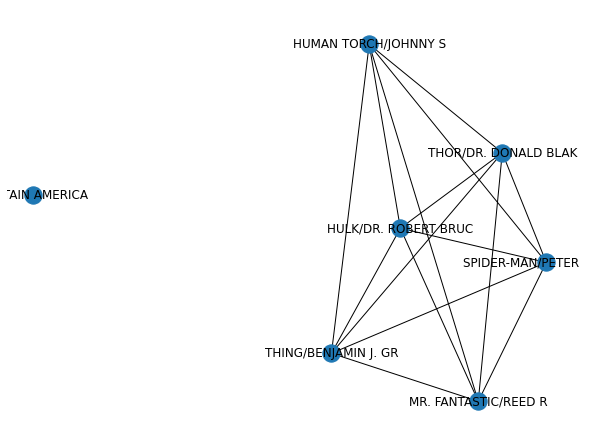

In [38]:
len_edges_to_remove, G3 = remove_minimum_cut_edges(G1_, 'CAPTAIN AMERICA', 'THOR/DR. DONALD BLAK')

print("The minuimum number of links (edges) necessary to separate Heroe A from Hero B are: " + str(len_edges_to_remove))

#Disconnected subgraphs
plt.figure(figsize=(8, 6))
nx.draw(G3, with_labels=True)

Graph 2

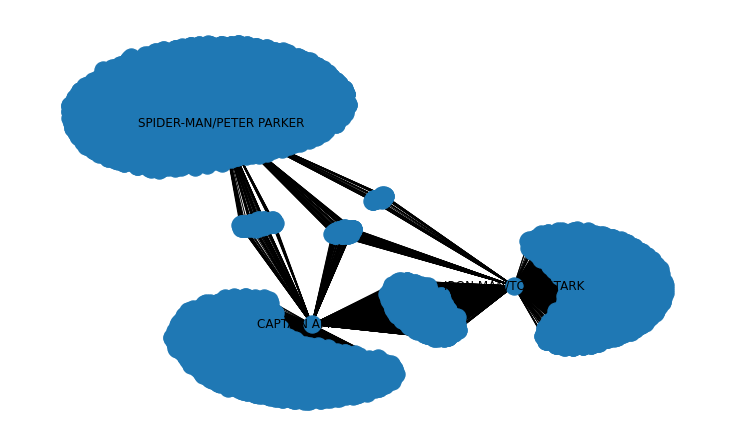

In [39]:
#Original graph
plt.figure(figsize=(10, 6))
# Draw hero nodes
selected_nodes = [node for node in G2.nodes if G2.nodes[node]['attr'] == 'hero']

# Draw a label for just the selected nodes
node_labels = {node:node for node in selected_nodes}
nx.draw(G2, with_labels=True, labels=node_labels)

In [40]:
#As an example, we choose Top N = 3 and Hero A: 'CAPTAIN AMERICA' and Hero B: 'IRON MAN/TONY STARK'.

len_edges_to_remove, G4 = remove_minimum_cut_edges(G2_, 'CAPTAIN AMERICA', 'IRON MAN/TONY STARK')

print("The minuimum number of links (edges) necessary to separate Heroe A from Hero B are: " + str(len_edges_to_remove))

The minuimum number of links (edges) necessary to separate Heroe A from Hero B are: 470


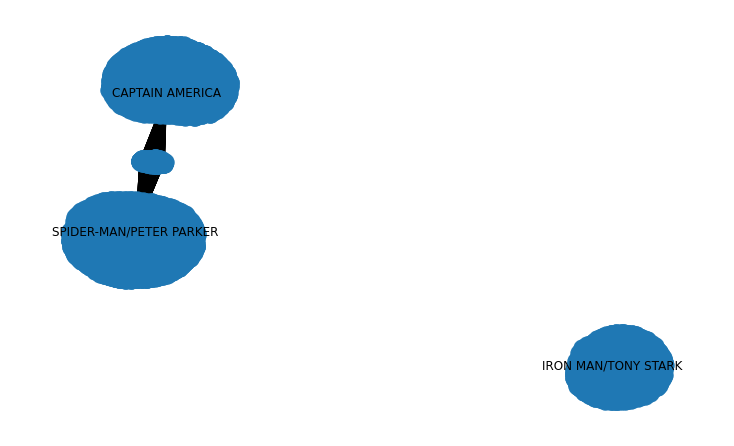

In [41]:
#Disconnected subgraphs
plt.figure(figsize=(10, 6))
# Draw hero nodes
selected_nodes = [node for node in G4.nodes if G4.nodes[node]['attr'] == 'hero']

# Draw a label for just the selected nodes
node_labels = {node:node for node in selected_nodes}
nx.draw(G4, with_labels=True, labels=node_labels)

## Functionality 5 - Extracting Communities

Input:

- The graph data
- N: denoting the top N heroes that their data should be considered
- Hero_1: denoting the name of one of the heroes
- Hero_2: denoting the name of one of the heroes

Output:

- The minimum number of edges that should be removed to form communities
- A list of communities, each containing a list of heroes that belong to them.
- If the Hero_1 and Hero_2 belongs to the same community

Important Notes:
This functionality should only be run on the first graph.

Graph 1

In [43]:
#With N=100
g_type, n_heroes = get_params(True)
print(g_type)
print(n_heroes)
G1 = create_graph(g_type, n_heroes)

Please enter the graph type:
Now enter n for the top n heroes:
1
100


In [44]:
#We use nx.Graph to convert the MultiGraph to a Graph
if type(G1) == nx.MultiGraph:
    G1_ = nx.Graph(G1.copy())

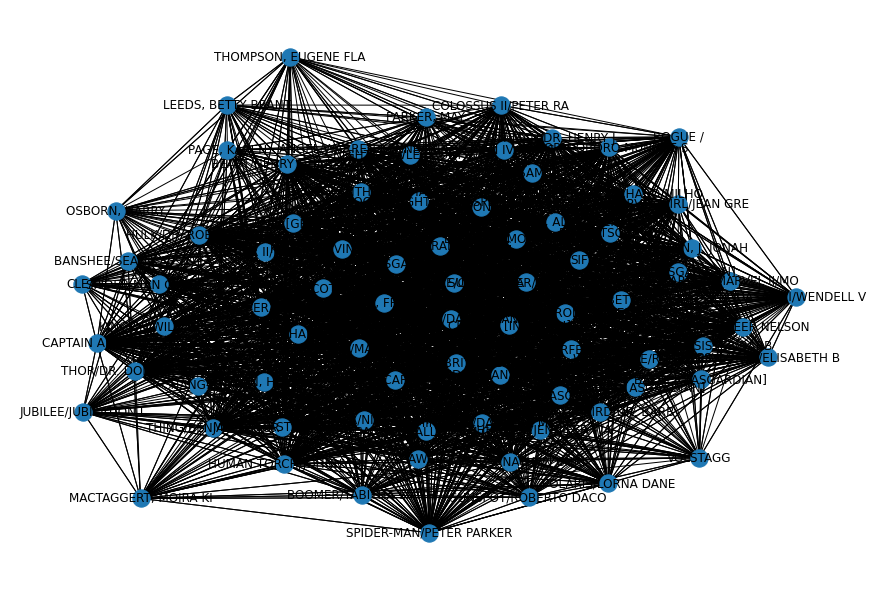

In [45]:
#Original Graph
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))

nx.draw(G1, with_labels=True)

- The edge_to_delete function returns the edge with the highest betweenness centrality in the input graph. 

- The girvan_newman function removes this edge from the graph and then checks the number of connected components in the resulting graph. If the graph still has only one connected component, the process is repeated until the graph has more than one connected component. The resulting connected components are returned as the communities in the graph

In [46]:
#Following the suggestion, the following code was mostly taken from the provided article.

def edge_to_delete(graph):
  #nx.edge_betweenness_centrality is going to return a dictionary of edges with betweenness centrality as the value
  G_EBC = nx.edge_betweenness_centrality(graph)
  edge = ()

  #Edge with highest edge betweenness centrality score
  for edge_dict, key  in sorted(G_EBC.items(), key=lambda item: item[1], reverse = True):
      edge = edge_dict
      break
  return edge

def girvan_newman(graph):
    #number of connected components
    comm = nx.connected_components(graph)
    comp_count = nx.number_connected_components(graph)
    #dictionary to store removed edges
    removed_edges = {}

    #If the number of connected components is greater than 1, the function returns the connected components.
    while(comp_count == 1):
        edge = edge_to_delete(graph)
        graph.remove_edge(edge_to_delete(graph)[0], edge_to_delete(graph)[1])
        comm = nx.connected_components(graph)
        comp_count = nx.number_connected_components(graph)
        removed_edges[edge] = True

    return comm, len(removed_edges)

## Visualization 5 - Visualize the communities

We anticipate seeing the Functionality 5 report in Visualization 5. To be more specific, we expect you to have the following report format:

- Print the number of links that should be removed to have the communities
- A table depicting the communities and the heroes that belong to each community
- Plot the original graph
- Plot the graph showing the communities in the network
- Plot the final graph and identify the community/communities of Hero_1 and Hero_2

Notes:

For the final output of your function, please set the Hero_1 to 'Captain America' and Hero_2 to 'Ironman' and show the results.

If Hero_1 and Hero_2 belong to the same community, identify that community; otherwise, identify those two communities that these heroes belong to.

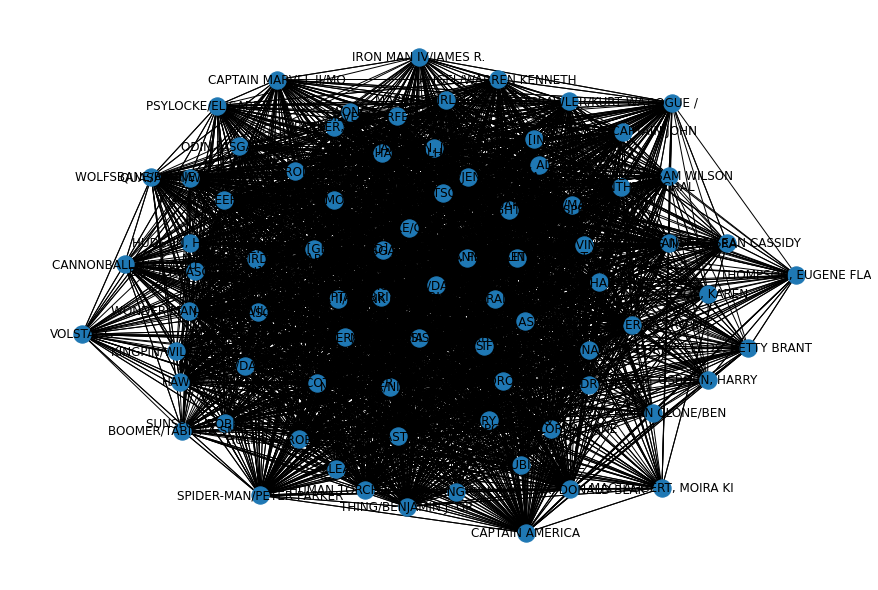

In [47]:
#Original Graph 1.
#As an example, we choose Top N = 100

plt.figure(figsize=(12, 8))

nx.draw(G1, with_labels=True)

In [48]:
#Find communities in the graph
G_aux = G1.copy()
communities, edges_to_remove = girvan_newman(G_aux)

#Nodes in the communities
communitiy_nodes = []

for i in communities:
  communitiy_nodes.append(list(i))

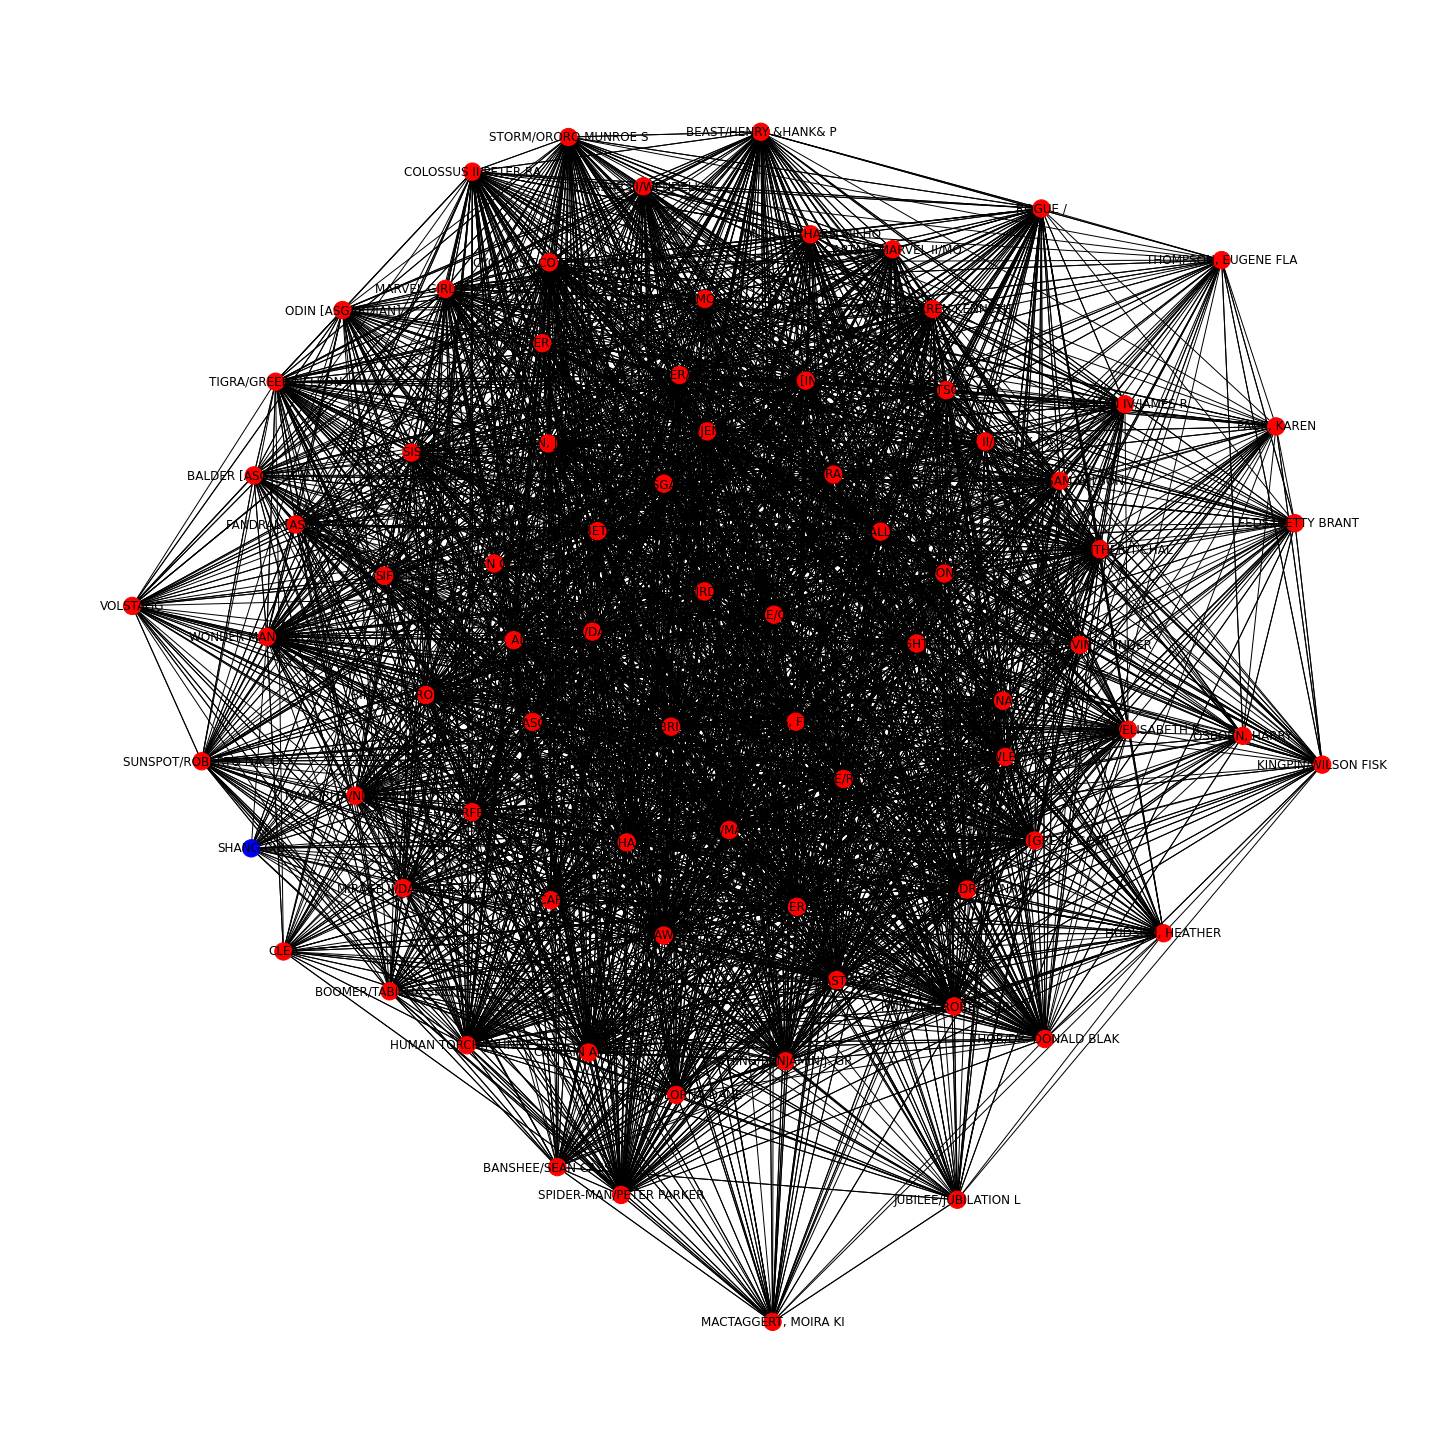

Communities:
Community 1: IRON FIST/DANIEL RAN LOKI [ASGARDIAN] NAMORITA/NITA PRENTI POLARIS/LORNA DANE PAGE, KAREN ROGUE / MR. FANTASTIC/REED R WOLFSBANE/RAHNE SINC SIF PSYLOCKE/ELISABETH B SPIDER-MAN CLONE/BEN MIRAGE II/DANIELLE M SUB-MARINER/NAMOR MA ODIN [ASGARDIAN] CANNONBALL II/SAM GU NORRISS, SISTER BARB MACTAGGERT, MOIRA KI NIGHTCRAWLER/KURT WA WONDER MAN/SIMON WIL KINGPIN/WILSON FISK HOGUN [ASGARDIAN] SUNSPOT/ROBERTO DACO THING/BENJAMIN J. GR JAMESON, J. JONAH BANNER, BETTY ROSS T SUMMERS, NATHAN CHRI CLEA BINARY/CAROL DANVERS ROBERTSON, JOE CAPTAIN MARVEL II/MO KA-ZAR/KEVIN PLUNDER NELSON, FRANKLIN FOG BALDER [ASGARDIAN] FALCON/SAM WILSON THOR/DR. DONALD BLAK COLOSSUS II/PETER RA DAREDEVIL/MATT MURDO QUASAR III/WENDELL V ANT-MAN/DR. HENRY J. MARVEL GIRL/JEAN GRE LEEDS, BETTY BRANT RICHARDS, FRANKLIN B QUICKSILVER/PIETRO M BEAST/HENRY &HANK& P MOON KNIGHT/MARC SPE NOVA/RICHARD RIDER CAPTAIN AMERICA BLACK PANTHER/T'CHAL SPIDER-MAN/PETER PARKER ANGEL/WARREN KENNETH WONG SILVER S

In [49]:
#Communities
graph_plot = []
for node in G1:
    if node in communitiy_nodes[0]:
        graph_plot.append('red')
    else: 
        graph_plot.append('blue')  

nx.draw(G1, node_color=graph_plot, with_labels=True)
plt.show()

print('Communities:')
for i, community in enumerate(communitiy_nodes):
    print(f'Community {i+1}:', *community)

print('Edges to remove: ' + str(edges_to_remove))

Community 1 is identified in red and Community 2 in blue.

In [50]:
def in_same_community(heroA, heroB, communities):
    for community in communities:
        if heroA in community and heroB in community:
            return True
    return False

heroA = 'CAPTAIN AMERICA'
heroB = 'IRON MAN IV/JAMES R.'

if in_same_community(heroA, heroB, communitiy_nodes):
    print(f"{heroA} and {heroB} are in the same community.")
else:
    print(f"{heroA} and {heroB} are in different communities.")

CAPTAIN AMERICA and IRON MAN IV/JAMES R. are in the same community.


# Algorithmic Question

Alex and Sarah have been together for two years, and Alex is now thinking about proposing to her. But, to surprise her, he wants to install an app on her phone that asks her if she will marry him at the right time.

However, to install the application secretly, he needs her **phone's password**, which he does not have. He knows her password is a **poly-line made up of vertical or horizontal line segments**. In a **3*3 grid**, each line segment connects the centres of two cells. Alex learned the direction of each line segment by looking at her hand while unlocking her phone. He didn't pay much attention to the length of each line segment, but he is sure that her phone's operating system **does not allow the poly-line to intersect with itself** even at one point.

Alex wants to distract Sarah's attention long enough to test **all possible patterns** based on the **directions of the line segments** he has learned. Therefore, he needs you to assist him in calculating how many possible patterns he has to try based on those directions to estimate how much time he needs to check all of those possibilities. Given that the line segments were directed **right, down, left, and up**, the following figure depicts two valid and one invalid (as the poly-lines should not intersect even in one point) patterns.

The input is a single string that shows the direction of the segment lines and contains only the characters R, L, U, and D, which correspond to the Right, Left, Up, and Down directions. The **string's maximum length is 10**. It is also **guaranteed that two consecutive characters will be different**.

In [212]:
def find_valid_patterns(s):
    count = 0
    
    # try to find patterns from every possible starting position
    for start_x in range(3):
        for start_y in range(3):
            
            count += find_pattern_from_pos(start_x, start_y, s)
    
    return count

In [213]:
# This code snippet is used below. It creates all theoretically possible patterns

s = list('LDR')
steps = [1, 2]

unique_combinations = list(list(zip(s, element)) for element in product(steps, repeat=len(s)))
unique_combinations

[[('L', 1), ('D', 1), ('R', 1)],
 [('L', 1), ('D', 1), ('R', 2)],
 [('L', 1), ('D', 2), ('R', 1)],
 [('L', 1), ('D', 2), ('R', 2)],
 [('L', 2), ('D', 1), ('R', 1)],
 [('L', 2), ('D', 1), ('R', 2)],
 [('L', 2), ('D', 2), ('R', 1)],
 [('L', 2), ('D', 2), ('R', 2)]]

In [214]:
def no_intersection(visited):
    return (len(visited) == len(np.unique(visited, axis=0)))

In [215]:
def is_not_outside(visited):
    return all((0 <= np.unique(visited)) & (np.unique(visited) < 3))

In [216]:
def find_pattern_from_pos(x, y, s):
    count = 0
    
    x_0, y_0 = x, y
    
    s = list(s)
    steps = [1, 2]
    
    unique_combinations = list(list(zip(s, element)) for element in product(steps, repeat=len(s)))
    
    for pattern in unique_combinations:
        valid = True
        visited = [(x_0, y_0)]
        x, y = x_0, y_0
        
        for direction, step in pattern:
            if direction == 'D':
                visited.extend([(x, y+i) for i in range(1, step + 1)])
                y += step
                
            if direction == 'R':
                visited.extend([(x+i, y) for i in range(1, step + 1)])
                x += step
                
            if direction == 'U':
                visited.extend([(x, y-i) for i in range(1, step + 1)])
                y -= step
                
            if direction == 'L':
                visited.extend([(x-i, y) for i in range(1, step + 1)])
                x -= step
        
        if no_intersection(visited) and is_not_outside(visited):
            count += 1
    
    return count

In [217]:
find_valid_patterns('DRU')

15

In [218]:
find_valid_patterns('R')

9

In [219]:
find_valid_patterns('LDRDRUL')

0